<h1>Prediction of Nitrite concentration using Artificial Neural Network and Generalized Additive Models</h1>

I have sensor data from my system which gives me concentrations of ammonium and nitrate, but I don't have a sensor to measure concentration of nitrite. I know the three nitrogen species are chemically related and their rates are dependent on each other, but not completely. However, since I have historical performance data from the same reactor, I am hoping this data will capture most of the variablilities. Thus, I would like to mine the data using machine learning techniques if it could give me a reasonable value for nitrite. Here, I have tried three different commonly used machine learning algorithms: multiple linear regression, artificial neural network and generalized additive models.

- [Import packages and load data](#sec1)
- [Multiple linear regeression](#sec2)
- [Artificial neural network using keras](#sec3)
- [Generalized additive models](#sec4)

## <a id='sec1'> </a> Import packages and load data

In [8]:
import pandas as pd

In [9]:
data = pd.read_csv('sensor_n.csv', sep='\t')

In [6]:
data.head()

,Ammonium,Nitrate,Nitrite
0,1.55,26.35,0.00
1,4.61,3.32,6.61
2,15.44,0.53,8.43
3,25.78,0.22,7.12
4,17.36,5.52,9.65


In [7]:
#from sklearn.linear_model import LinearRegression
X = data[['Ammonium','Nitrate']]
y = data['Nitrite']
#no2_lm = LinearRegression().fit(X, y)
#no2_lm.score(X, y)

##  <a id='sec2'> </a> Let us trying fitting linear regression

Before we jump to using ANN, let us try fit a multiple linear regression model and see the performance. For this I will use the `statsmodels` api the `OLS` (ordinary least regresion) function.

In [120]:
import statsmodels.api as sm

In [121]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

c:\users\zerua\appdata\local\conda\conda\envs\py36_64\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Nitrite   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     75.14
Date:                Thu, 09 May 2019   Prob (F-statistic):           1.03e-21
Time:                        19:29:11   Log-Likelihood:                -361.21
No. Observations:                 120   AIC:                             728.4
Df Residuals:                     117   BIC:                             736.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.9006      0.815     20.746      0.000      15.287      18.514
Ammonium      -0.4815      0.069     -7.019      0.000      -0.617      -0.346
Nitrate       -0.5961      0.050    -12.026      0.000      -0.694      -0.498
==============================================================================
Omnibus:                       18.466   Durbin-Watson:                   1.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.915
Skew:                           0.635   Prob(JB):                     1.59e-08
Kurtosis:                       5.360   Cond. No.                         23.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using multiple linear regression result an Ok model, but it is not good enough. Thus a linear relationship did not fit well for this model. Next, I will try using ANN using the `keras` package.

## <a id='sec3'> </a>  ANN model using the Keras API

In [122]:
import tensorflow as tf

In [2]:
from tensorflow import keras

print(tf.VERSION)
print(keras.__version__)

1.13.0-rc2
2.2.4-tf


Let us plot a pairplot to see the distribution of the feature variables.

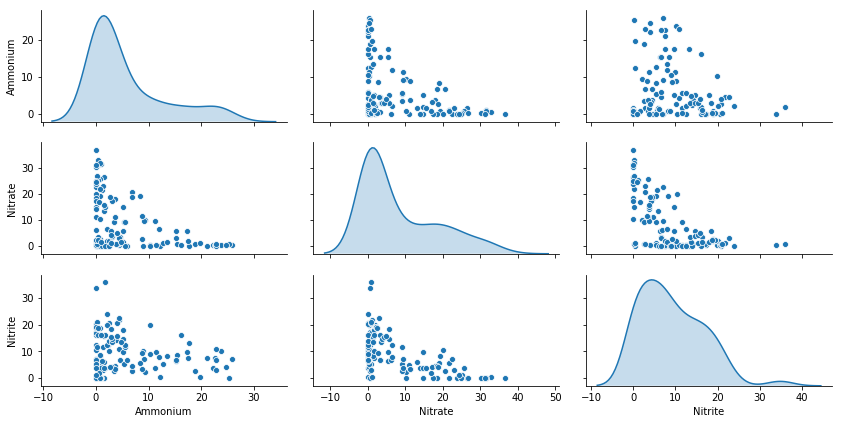

In [9]:
import seaborn as sns
sns.pairplot(data, diag_kind="kde", height=2, aspect=2)

Before we build the ANN model we need to standardize our data to avoid the effect of unit and magnitude difference in the feature variables.

In [10]:
data_mean = data.mean()
data_std = data.std()
norm_data = (data-data_mean)/data_std
norm_data.describe()

,Ammonium,Nitrate,Nitrite
count,1.200000e+02,1.200000e+02,1.200000e+02
mean,2.590520e-16,-1.776357e-16,-2.590520e-16
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.972429e-01,-8.249187e-01,-1.231318e+00
25%,-7.355950e-01,-7.933110e-01,-7.565472e-01
50%,-4.301112e-01,-5.456761e-01,-2.126573e-01
75%,4.181490e-01,6.728368e-01,7.184313e-01
max,2.754222e+00,2.822656e+00,3.586855e+00


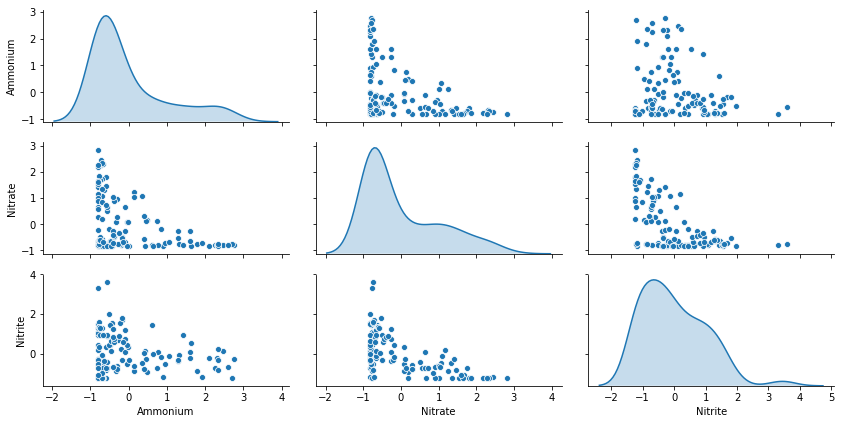

In [11]:
sns.pairplot(norm_data, diag_kind="kde", height=2, aspect=2)

Next, I will build the ANN model which has three hidden layers and an output layer with one perceptron. The choice of the ANN model architecture at this point is arbitrary, but we can try later different model architecture to improve the model's performance.

In [88]:
#from keras.layers import Dense
from tensorflow.keras import layers
import numpy as np
    
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=(2,)),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(lr=0.001)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error'])
    return model

In [89]:
model=build_model()

In [90]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_49 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_50 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 33        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


Next, we will fit/train the model as show below using the `model.fit` function.

In [91]:
EPOCHS = 250 # Number of iterations

history = model.fit( X, y, epochs=EPOCHS, validation_split = 0.2, verbose=0)

In [92]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
245,21.789733,3.283959,10.966087,2.533762,245
246,20.793131,3.077481,11.351815,2.545471,246
247,20.674088,3.164247,11.444407,2.569648,247
248,20.911383,3.219277,14.614449,2.745522,248
249,20.544966,3.112924,9.801442,2.596714,249


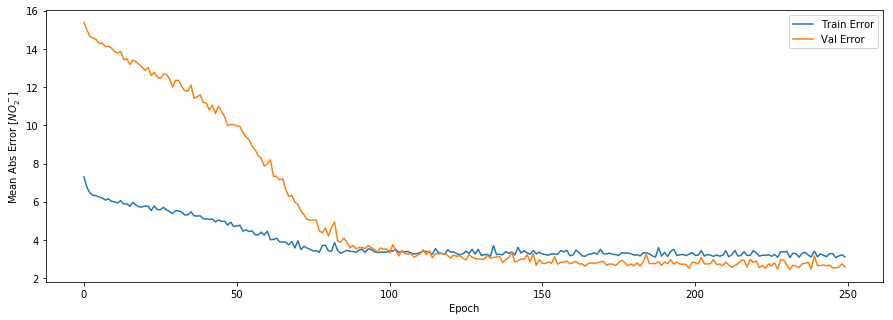

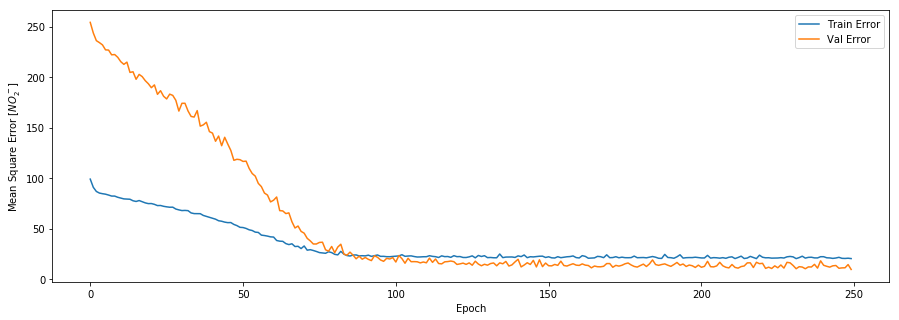

In [94]:
import matplotlib.pyplot as plt
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure(figsize=(15,5))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [$NO_2^-$]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
    
    #plt.ylim([0,5])
    plt.legend()

    plt.figure(figsize=(15,5))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$NO_2^-$]')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
             label = 'Val Error')
    #plt.ylim([0,20])
    plt.legend()

    plt.show()

plot_history(history)

In [98]:
training_predictions = model.predict(X) #.flatten()

In [99]:
#Check correlation coefficient of predicted vs observed 
import numpy as np
print(f'Pearson\'s correlation coefficient = {np.corrcoef(training_predictions.flatten(),y)[0,1]:.2f}')

Pearson's correlation coefficient = 0.81


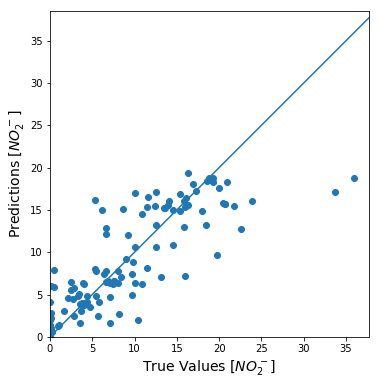

In [55]:
plt.figure(figsize=(6,6))
plt.scatter(y, training_predictions)
plt.xlabel('True Values [$NO_2^-$]', fontsize=14)
plt.ylabel('Predictions [$NO_2^-$]', fontsize=14)
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

### Model prediction

Let us load the test data.

In [17]:
test_data = pd.read_csv('nitrite_test.csv', sep='\t')
X_test = test_data[['Ammonium','Nitrate']]
y_test = test_data['Nitrite']

In [100]:
loss, mae = model.evaluate(X_test, y_test, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Nitrite".format(mae))
print("Testing set Mean squared Error: {:5.2f} mg/L N-Nitrite".format(mse))

test_predictions = model.predict(X_test).flatten()
print(f'Pearson\'s correlation coefficient = {np.corrcoef(test_predictions.flatten(),y_test)[0,1]:.2f}')

Testing set Mean Abs Error:  2.68 Nitrite
Testing set Mean squared Error: 18.11 mg/L N-Nitrite
Pearson's correlation coefficient = 0.47


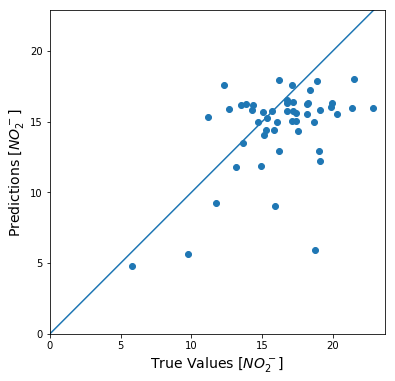

In [127]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [$NO_2^-$]', fontsize=14)
plt.ylabel('Predictions [$NO_2^-$]', fontsize=14)
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0, 100], [0, 100])

##  <a id='sec4'> </a> Prediction using GAM

I am going to use R to do the generalized additive model (GAM). To use R from a python jupyter notebook, I am going to use the `rpy2` and `rmagic` packages together to call R functions. I can also reuse the variable betweeen R and python.

In [2]:
import rpy2.rinterface
%load_ext rpy2.ipython

In [4]:
%%R
# Install the mgcv package for GAM
install.packages('mgcv')

In [5]:
%%R -i data -o mod_sum

library(mgcv)
model <- gam(Nitrite ~ s(Ammonium, bs='ps', sp=0.1)+s(Nitrate, bs='ps', sp=0.1), data = data)
summry(model)  #This prints to console
mod_sum <- summary(model)

In [43]:
print(mod_sum)



Family: gaussian 

Link function: identity 



Formula:

Nitrite ~ s(Ammonium, bs = "ps", sp = 0.1) + s(Nitrate, bs = "ps", 

    sp = 0.1)



Parametric coefficients:

            Estimate Std. Error t value Pr(>|t|)    

(Intercept)    9.175      0.438   20.95   <2e-16 ***

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Approximate significance of smooth terms:

              edf Ref.df      F  p-value    

s(Ammonium) 7.798  8.368  6.146 9.23e-07 ***

s(Nitrate)  7.661  8.118 19.147  < 2e-16 ***

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



R-sq.(adj) =  0.585   Deviance explained = 63.9%

GCV = 26.676  Scale est. = 23.017    n = 120



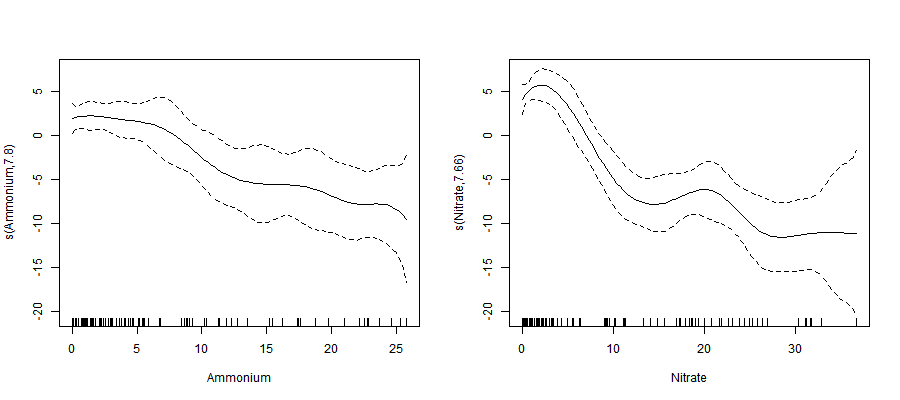

In [36]:
%%R -w 900 -h 400

par(mfrow=c(1,2))
plot(model)

In [19]:
%%R -i X_test -o no2_gam

#x_new = test_data[,c('Ammonium','Nitrate')]
no2_gam <- predict(model, newdata=X_test)

In [45]:
# Read from r GAM output
import numpy as np

no2_gam_r = np.array(no2_gam)

In [103]:
x_axis=range(0,len(test_predictions))

In [47]:
np.corrcoef(y_test,no2_gam_r)[0,1]

0.5187474131044831

In [105]:
np.corrcoef(y_test,test_predictions)[0,1]

0.4720899990732165

Next, let us plot and compare both ANN and GAM results as shown below.

Text(0.5, 1.0, 'Nitrite prediction vs observed')

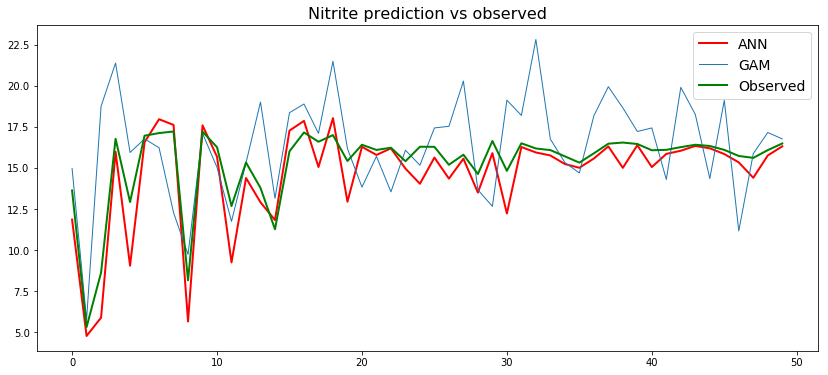

In [119]:
plt.figure(figsize=(14,6))
plt.plot(x_axis, test_predictions, 'r', linewidth=2, label='ANN')
plt.plot(x_axis, y_test, linewidth=1, label='GAM')
plt.plot(x_axis, no2_gam_r, 'g', linewidth=2, label = 'Observed')
plt.legend(fontsize=14)
plt.title('Nitrite prediction vs observed', fontsize=16)

# Conclusion

As we saw above using ANN resulted in a much better estimate (correlation = 0.81) of nitrite compared to multiple linear regession (correlation = 0.51).

In [123]:
#test_predictions